<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></div>

#  Определение региона для добычи нефти, анализ прибыли и рисков

Нефтедобывающей компании N нужно решить, где бурить новую скважину.  
В распоряжении имеются пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

***Задачи:***
* Построение модели машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
* Анализ возможной прибыли и рисков техникой Bootstrap.

***Описание данных***
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

***Шаги для выбора локации:***
* Поиск месторождения в избранном регионе, определение значения признаков;
* Построение модели и оценка объёма запасов;
* Выбор месторождения с самыми высокими оценками значений (количество месторождений зависит от бюджета компании и стоимости разработки одной скважины);
* Расчёт прибыли (равна суммарной прибыли отобранных месторождений).

***Условия задачи:***
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
* Бюджет на разработку скважин в регионе — 10 млрд рублей;
* Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
# импортируем необходимые для работы бибилиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
# прочитаем и сохраним данные
geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('/datasets/geo_data_2.csv')


In [3]:
# создадим словарь с наименованием и данными по регионам
datasets = {'Регион-1': geo_1, 'Регион-2': geo_2, 'Регион-3': geo_3}


In [4]:
# выведем информацию о данных по каждому региону
for name, df in datasets.items():
    print(f'{name}\n')
    print(f'Объектов: {df.shape[0]}')
    print(f'Признаков: {df.shape[1]}')
    print(f'Пропусков: {df.isna().sum().sum()}')
    print(f'Дубликатов: {df.duplicated().sum()}')
    print(f'Нулевых значений целевого признака: \
{df[df["product"] == 0]["id"].count()}')
    print('\nПервые объекты таблицы:')
    display(df.head())
    print('\nКорреляция признаков:')
    display(df.corr())
    print('\nОписательная статистика числовых значений таблицы:')
    display(df.describe())
    print('.' * 55, end='\n\n\n')
    

Регион-1

Объектов: 100000
Признаков: 5
Пропусков: 0
Дубликатов: 0
Нулевых значений целевого признака: 1

Первые объекты таблицы:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Корреляция признаков:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000



Описательная статистика числовых значений таблицы:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


.......................................................


Регион-2

Объектов: 100000
Признаков: 5
Пропусков: 0
Дубликатов: 0
Нулевых значений целевого признака: 8235

Первые объекты таблицы:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Корреляция признаков:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000



Описательная статистика числовых значений таблицы:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


.......................................................


Регион-3

Объектов: 100000
Признаков: 5
Пропусков: 0
Дубликатов: 0
Нулевых значений целевого признака: 1

Первые объекты таблицы:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Корреляция признаков:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000



Описательная статистика числовых значений таблицы:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


.......................................................




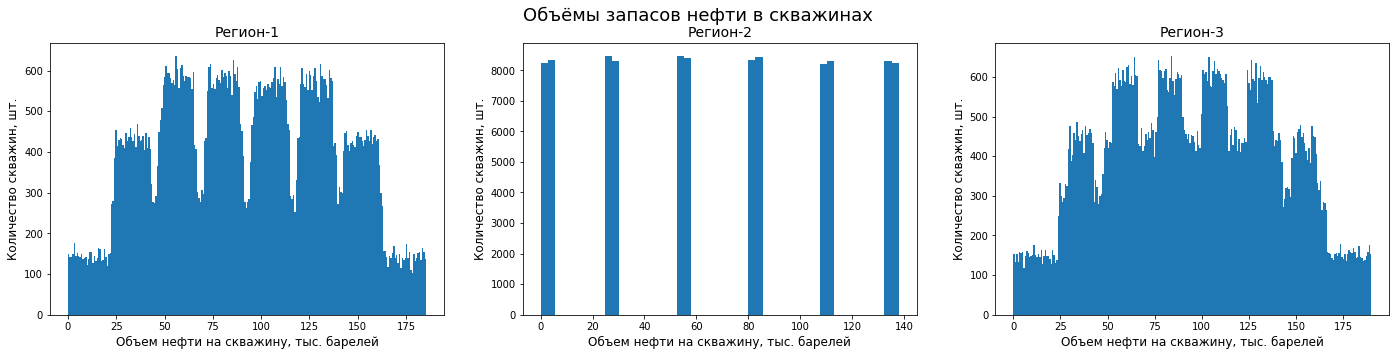

In [5]:
# ознакомимся подробнее с объёмами запасов нефти по регионам
# построим гистограммы распределения запасов в скважинах
fig = plt.figure(figsize=(24, 5))
fig.suptitle('Объёмы запасов нефти в скважинах', size = 18)

ax_1, ax_2, ax_3 = (fig.add_subplot(1, 3, 1),
                    fig.add_subplot(1, 3, 2),
                    fig.add_subplot(1, 3, 3),)

for ax in (ax_1, ax_2, ax_3):
    ax.set_xlabel('Объем нефти на скважину, тыс. барелей', size=12)
    ax.set_ylabel('Количество скважин, шт.', size=12)
    
ax_1.hist(geo_1['product'], bins = 250)
ax_1.set_title('Регион-1', size=14)

ax_2.hist(geo_2['product'], bins = 50)
ax_2.set_title('Регион-2', size=14)

ax_3.hist(geo_3['product'], bins = 250)
ax_3.set_title('Регион-3', size=14)

plt.show()


### Выводы
* Данные загружены и изучены, необходимости в обработке - не выявлено (отсутствуют пропуски и дубликаты, нет значимой корреляции между признаками);
* Исходя из представленных данных, Регион-2 содержит наименьший средний объём запасов сырья в скважине — 68.8 тыс. баррелей, против 92.5 и 95.0 тыс. баррелей в Регионе-1 и Регионе-3 соответственно;
* В ключевом признаке Регионе-2 содержится 8.2% нулевых значений, что может говорить об утере данных о пробах или о пренебрежительно низких объёмах залежей в скважинах;
* В Регионе-1 и Регионе-3 распределение запасов сырья в скважинах стремиться к нормальному, в Регионе-2 распределение выглядит странно и не подчиняется закону больших чисел, что, в общем, соотносится с информацией из документации "Данные синтетические".


## Обучение и проверка модели

In [6]:
# напишем функцию для разбиения данных, обучения модели и предсказания
# функция возвращяет предсказания и правильные ответы
def split_and_predict(df):
    
    # определим признаки и ключевой признак
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    # разделим данные на обущающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = (
        train_test_split(features,
                         target,
                         test_size=0.25,
                         random_state=12345,)
    )
    
    # обучим модель линейной регрессии и
    # сделаем предсказания на валидационной выборке
    reg = LinearRegression().fit(X_train, y_train)
    predictions = pd.Series(reg.predict(X_valid))
    
    return predictions, y_valid.reset_index(drop=True)


In [7]:
# выведем на экран средний запас предсказанных объёмов сырья
# и значение метрики RMSE для каждого региона
for name, df in datasets.items():
    predictions, answers = split_and_predict(df)
    average_product = predictions.mean()
    rmse = mean_squared_error(answers, predictions, squared=False)
    
    print(f'\n{name}\n')
    print(f'Cредний запас фактических объёмов сырья (тыс. баррелей): \
{round(df["product"].mean(), 2)}')
    print(f'Cредний запас предсказанных объёмов сырья (тыс. баррелей): \
{round(average_product, 2)}')
    print(f'RMSE: {round(rmse, 2)}\n')
    print('.' * 65)
    


Регион-1

Cредний запас фактических объёмов сырья (тыс. баррелей): 92.5
Cредний запас предсказанных объёмов сырья (тыс. баррелей): 92.59
RMSE: 37.58

.................................................................

Регион-2

Cредний запас фактических объёмов сырья (тыс. баррелей): 68.83
Cредний запас предсказанных объёмов сырья (тыс. баррелей): 68.73
RMSE: 0.89

.................................................................

Регион-3

Cредний запас фактических объёмов сырья (тыс. баррелей): 95.0
Cредний запас предсказанных объёмов сырья (тыс. баррелей): 94.97
RMSE: 40.03

.................................................................


### Выводы
* Написана функция для разбиения данных на обучающую и валидационную выборки в соотношении 3:1, обучения модели и предсказания;
* Средние запасы фактического и предсказанного объёмов сырья практически совпадают;
* Метрика RMSE модели для Региона-2 = 0.89 (в данном случае практически идеальная работа модели), что, вероятно, является следствием очень высокой корреляции признака f2 с ключевым признаком - объёмом запасов в скважине (корреляция = 0.999).


## Подготовка к расчёту прибыли

In [8]:
# сохраним ключевые значения для дальнейших расчётов
Research_points = 500
Best_points = 200
Budget = 10_000_000_000
Incom_per_product = 450_000


In [9]:
# рассчитаем объём сырья для безубыточной разработки лучших скважин
required_volume = Budget / Incom_per_product

print(f'Объём сырья для безубыточной разработки {Best_points} \
лучших скважин в регионе (тыс. баррелей): {round(required_volume, 2)}')
print(f'Необходимый средний объём сырья на скважину (тыс. баррелей): \
{round(required_volume / Best_points, 2)}')


Объём сырья для безубыточной разработки 200 лучших скважин в регионе (тыс. баррелей): 22222.22
Необходимый средний объём сырья на скважину (тыс. баррелей): 111.11


In [10]:
# напишем функцию для расчёта прибыли
# по выбранным лучшим скважинам и предсказаниям модели
def revenue(predictions, answers):
    predicts_sorted = predictions.sort_values(ascending=False)  
    best_answers = answers[predicts_sorted.index][:Best_points]
    
    return best_answers.sum() * Incom_per_product - Budget


### Выводы
* Проведена подготовка к расчёту прибыли, определены и сохранены ключевые значения;
* Рассчитан объём сырья для безубыточной разработки лучших скважин: 22222.22 тыс. баррелей;
* Необходимый при этом средний объём сырья на скважину равен 111.11 тыс. баррелей, что больше, чем средний фактический объём в любом из регионов;
* Написана функция для расчёта прибыли по выбранным лучшим скважинам и предсказаниям модели.


## Расчёт прибыли и рисков 

In [11]:
# напишем функцию для расчёта прибыли и риска убытков для каждого региона
def profit_and_risk_calc(df):
    predictions, answers = split_and_predict(df)
    state = np.random.RandomState(12345)
    values = []
    losts_cnt = 0
    for _ in range(1_000):
        answers_subsample = answers.sample(n=Research_points, 
                                           replace=True, 
                                           random_state=state,)
        predicts_subsample = predictions[answers_subsample.index]
        rev = revenue(predicts_subsample, answers_subsample)
        values.append(rev)
        if rev < 0:
            losts_cnt += 1
            
    values = pd.Series(values)
    mean_revenue = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = losts_cnt / 1_000
    
    return mean_revenue, lower, upper, risk


In [12]:
# выведем на экран средную прибыль, 95%-й доверительный интервал
# и риск убытков для каждого региона
for name, df in datasets.items():
    mean_revenue, lower, upper, risk = profit_and_risk_calc(df)
    print(f'\n{name}\n')
    print(f'Cредняя прибыль (тыс. руб.): {round(mean_revenue, 2)}')
    print(f'95%-й доверительный интервал (тыс. руб.): \
{round(lower, 2)} / {round(upper, 2)}')
    print(f'Риск убытков: {risk:.1%}\n')
    print('.' * 70)
    


Регион-1

Cредняя прибыль (тыс. руб.): 425938526.91
95%-й доверительный интервал (тыс. руб.): -102090094.84 / 947976353.36
Риск убытков: 6.0%

......................................................................

Регион-2

Cредняя прибыль (тыс. руб.): 515222773.44
95%-й доверительный интервал (тыс. руб.): 68873225.37 / 931547591.26
Риск убытков: 1.0%

......................................................................

Регион-3

Cредняя прибыль (тыс. руб.): 435008362.78
95%-й доверительный интервал (тыс. руб.): -128880547.33 / 969706954.18
Риск убытков: 6.4%

......................................................................


### Выводы
* Рассчитана средняя прибыль, 95%-й доверительный интервал и риск убытков для каждого региона, применена техника "Bootstrap";
* Исходя из расчётов, наиболее привлекательным для разработки месторождений является Регион-2, где средняя прибыль максимальна, а риск убытков минимальный в сравнении с другими регионами (1.0% против 6.0% и 6.4% для Региона-1 и Региона-3 соответственно).
